In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from asymmetric_laplacian_distribution import generate_ALF_data, get_index_per_class, get_labels, labels_to_layout_mapping
import functions_for_plotting 
from prediction_strength import get_statistic_score_per_k
from training_set_split import get_training_folds
from spectral_clustering import spectral_clustering
import prediction_strength
from matplotlib.legend import Legend
import wagenaar_dataset

/Users/paule/anaconda3/envs/bon17/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.nearest_centroid module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


# F1-Score

Let's define:

- True positives: same cluster in training, same cluster in validation  
- False positives: different cluster in training, same cluster in validation  
- True negatives: different cluster in training, different cluster in validation  
- False negatives: same cluster in training, different cluster in validation  

(It is actually wrong to talk about *'true'* and *'false'' rather we should talk about *'plausible positives'* and so on but for the sake of understanding we keep it that way.)

Same cluster in training means that two points fall in the same cluster when we cluster them based on training set centroids found by separatly clustering the training dataset.
Same cluster in validation means that two points fall in the same cluster after clustering the data with our spectral clustering method.

## The prediction strength introduced by Tibshirani & Walther in 2005 (Tibshirani & Walther 2005) is defined as:

$ps(k) = \underset{1 \leq j \leq k}{min}\frac{1}{n_{kj}(n_{kj}-1)} \underset{i \neq i'\in A_{kj}}{\sum} D[C(X_{tr},k),X_{te}]_{ii'}$

For each cluster in a clutering with k clusters we calculate the proportion of pairs in that cluster which are also assigned to the same cluster by training set centroids.
The size of cluster $j$ in a clustering with $k$ clusters is defined by $n_{kj}$.
$A_{kj}$ is the set of points in cluster $j$ for a clustering with $k$ clusters.
$C(X_{tr},k)$ is the oparation of clustering the data into $k$ clusters (in our case the usage of spectral clustering to cluster the data into k clusters).
$D[C(X_{tr},k), X_{te}]$ is the so called *'co-membership'* matrix. If the observations $i$ and $i'$ from $X_{te}$ fall in the same cluster of $C(X_{tr},k)$ the entry is equal to 1 otherwise 0.
We sum the number of true positives for each cluster and devide them by the number of all possible pairs for this cluster. So we end up with a term similar to the $precision = \frac{TP}{(TP + FP)}$


## The F1-Score is defined as:

$F1 = 2 \cdot \frac{Precision \cdot Recall}{Precision + Recall}$
with $precision = \frac{TP}{(TP + FP)}$ and $(sensitivity) recall= \frac{TP}{(TP + FN)}$.
Therefore $F1$ Score can be formulated by: $F1 = 2\cdot \frac{TP}{(2TP + FP + FN)}$

The F1 score is said to be a balance between *Precision* and *Recall*. In contrast to the accuracy it does not care about the number of true negatives, which can be handy if there is a large number of "irrelavant" negatives cases but can be misleading for unbalanced classes.

---
Tibshirani, R. & Walther, G. Cluster validation by prediction strength. J. Comput. Graph. Statist. 14, 511–528 (2005)  

# Dataset

In [2]:
data_dir = "data/raw_data/daily_spontanous_dense/day20/"
data = np.load(data_dir + "data_burst_by_time_day_20.npy").T
culture_dict = np.load(data_dir + "culture_dict_day_20.npy").item()

NameError: name 'np' is not defined

# F1- Scores

In [2]:
score_dict = ""

In [ ]:
score_files = [score_dict+ 'F1_day20_21_Euclidean_k=10_reg=None_5_fold_random_train_100clusters_jackknife_one_fifth_centroid_vs_total.npy',
              score_dict +'F1_day20_21_Euclidean_k=10_reg=None_5_fold_random_train_100clusters_jackknife_one_fifth_centroid_vs_total_clusterwise.npy',
              score_dict +'F1_day20_21_Euclidean_k=10_reg=None_5_fold_random_train_100clusters_jackknife_four_fifth_separate_vs_total_centroid.npy',
              score_dict +'F1_day20_21_Euclidean_k=10_reg=None_5_fold_random_train_100clusters_jackknife_four_fifth_separate_vs_total_centroid_clusterwise.npy']

In [ ]:
scores = []
for file in score_files:
    scores.append(np.load(file,allow_pickle=True).item())

In [15]:
keys = ["F1-Score: 1/5 centroid vs. total separate",
        "F1-Score: 1/5 centroid vs. total separate (clusterwise)",
        "F1-Score: 4/5 separate vs. total centroid",
       "F1-Score: 4/5 separate vs. total centroid (clusterwise)"] 

# Plot Mean F1-Scores

In [ ]:
figsize=(20,10)
plot_adjustments = [0.05,0.08,0.95, 0.86]
save_file = "Scores_day20_21__Euclidean_k=10_reg=None_weighting=False_5_fold_random_100clusters_jackknife.pdf"
title = "Mean Scores of clusters found in a 5 fold random split \n Wagenaar Day20+21 Dataset with jackknife method (averaged over folds) \n reg=None"

In [ ]:
fig, ax = plt.subplots(figsize=figsize)
k_clusters = range(1,101)
#k_clusters = range(1,21)

scores_lines = []
scores_max_points = []
scores_max_points_labels = []
for i,key in enumerate(keys):
    scores_key = scores[i]
    
    mean_scores_k = []
    for k in list(scores_key.keys()):
        if len(np.asarray(scores_key[k]).shape) == 1:
            mean_scores_k.append(scores_key[k])
        else:
            mean_scores_k.append(np.mean(scores_key[k], axis=1))

    mean_fold_scores = np.mean(mean_scores_k,axis=1)
    std_fold_scores = np.std(mean_scores_k,axis=1)
    
    argmax_scores= np.argmax(mean_fold_scores[1:]) + 1
    
    if "clusterwise" in key: 
        scores_lines += ax.plot(k_clusters, mean_fold_scores, "v:", label=key, color = "C0%d" % (i//2),linewidth=3)
        scores_max_points += [ax.scatter(k_clusters[argmax_scores], mean_fold_scores[argmax_scores], color = "C0%d"  % (i//2), marker="v",s=300)]
    else:
        scores_lines += ax.plot(k_clusters, mean_fold_scores, "o-", label=key, color = "C0%d" % (i//2),linewidth=3)
        scores_max_points += [ax.scatter(k_clusters[argmax_scores], mean_fold_scores[argmax_scores], color = "C0%d"  % (i//2), marker="o",s=300)]
    scores_max_points_labels +=  ["#%d|Score=%.3f" % (argmax_scores+1, mean_fold_scores[argmax_scores])]
    plt.fill_between(k_clusters, mean_fold_scores-std_fold_scores, mean_fold_scores+std_fold_scores, alpha=.3, color = "C0%d"  % (i//2))
    
    

ax.set_title(title, fontsize=22, pad=20)
ax.set_xticks(k_clusters)
ax.set_xlabel("# Number of clusters", fontsize=18, labelpad=10)
ax.set_ylabel("Score", fontsize=18, labelpad=10),
ax.set_ylim((0, 1.1))
#ax.set_ylim((0, 1000000))
ax.tick_params(axis='y',labelsize=14)
ax.tick_params(axis='x',labelsize=14,rotation=-90)

ax.set_yticks(np.arange(0, 1.1,0.1))
left = plot_adjustments[0]
bottom = plot_adjustments[1]
right = plot_adjustments[2]
top = plot_adjustments[3]

plt.subplots_adjust(left,bottom,right, top)

ax.legend(scores_lines, keys,fontsize = 14, loc="lower right")
leg = Legend(ax, scores_max_points,scores_max_points_labels,fontsize = 14, loc="lower left", title = "Maximum Score", )
leg.get_title().set_fontsize('16')
ax.add_artist(leg)
#plt.savefig(save_file)

# Clusterwise Analysis

In [271]:
f1_scores_based_on_training_centroids=True
labels_dict = ""
threshold = 0.9
top_n = 10

In [197]:
train_fold_indices, valid_fold_indices = get_training_folds(day20_data,None, cluster_split = "random",folds = 5)

In [259]:
clustered_labels_folds_train = np.load(labels_dict+ "labels_day20_Euclidean_k=10_reg=1_5_fold_random_train_100clusters.npy",allow_pickle=True)
clustered_labels_folds_valid = np.load(labels_dict+ "labels_day20_Euclidean_k=10_reg=1_5_fold_random_valid_100clusters.npy",allow_pickle=True)

In [272]:
mean_clusterwise_folds = []
min_clusterwise_folds = []
mean_clusterwise_size_weighted_folds = []
#min_clusterwise_size_weighted_folds = []

clusters_above_threshold_folds = []
clusters_above_threshold_proportional_folds = []
clusters_above_threshold_size_folds = []

highest_nclusters_folds = []
mean_highest_nclusters_folds = []
min_highest_nclusters_folds = []
mean_highest_nclusters_size_weighted_folds = []
mean_highest_nclusters_proportional_weighted_folds = []
bursts_in_top_n_clusters_folds = []


bursts_from_clear_clusters_in_highest_n_folds = []
proportion_bursts_from_clear_clusters_in_highest_folds = []
bursts_form_clear_clusters_in_clusters_above_threshold_folds = []
proportion_bursts_form_clear_clusters_in_clusters_above_threshold_folds = []

for f in range(folds):    
    f1_dict = np.load(f1_score_fold_files[f][f1_scores_based_on_training_centroids],allow_pickle=True).item()
    mean_clusterwise = []
    min_clusterwise = []
    mean_clusterwise_size_weighted = []
    #min_clusterwise_size_weighted = []
   
    clusters_above_threshold = []
    clusters_above_threshold_proportional = []
    clusters_above_threshold_size = []
    
    highest_nclusters = []
    mean_highest_nclusters = []
    min_highest_nclusters = []
    mean_highest_nclusters_size_weighted = []
    bursts_in_top_n_clusters = []
    
    bursts_from_clear_clusters_in_highest_n = []
    proportion_bursts_from_clear_clusters_in_highest = []
    bursts_form_clear_clusters_in_clusters_above_threshold = []
    proportion_bursts_form_clear_clusters_in_clusters_above_threshold = []

    

    for i,clusters in enumerate(range(1,101)):
        scores = f1_dict[clusters]
        labels = clustered_labels_folds_valid[f][i]
        _, cluster_counts = np.unique(labels, return_counts=True)

    
        mean_weighted_scores = np.sum(scores*cluster_counts)/len(labels)  
        #min_weighted_scores = np.amin(scores*cluster_counts)/len(labels)  
        mean_score = np.mean(scores)
        min_score = np.amin(scores)
        
        clusters_above_threshold_i = len(np.where(scores>=threshold)[0])
        clusters_above_threshold_proportional_i = clusters_above_threshold_i/clusters
        clusters_above_threshold_size_i = np.sum(cluster_counts[np.where(scores>=threshold)])#/len(labels)
        clusters_above_threshold_proportional_and_size_i = clusters_above_threshold_proportional_i*np.sum(cluster_counts[np.where(scores>=threshold)])/len(valid_fold_indices[f])
        
        
        highest_nclusters_i = np.argsort(scores)[-top_n:]
        highest_nclusters_scores = np.sort(scores)[-top_n:]
        mean_highest_nclusters_score = np.mean(highest_nclusters_scores)
        min_highest_nclusters_score = np.amin(highest_nclusters_scores)
        mean_highest_nclusters_size_weighted_score = np.sum(highest_nclusters_scores*cluster_counts[highest_nclusters_i])/len(labels)#np.sum(cluster_counts[highest_nclusters_i])
        bursts_in_top_n_clusters_i = np.sum(cluster_counts[highest_nclusters_i])
        
        
        """
        bursts_from_clear_clusters_in_highest_n_i = []
        bursts_form_clear_clusters_in_clusters_above_threshold_i = []
        
        for c in highest_nclusters_i:
            bursts_in_c = valid_fold_indices[f][np.where(clustered_labels_folds_valid[f][i] == c)[0]]
            clear_bursts_in_c = np.where(np.isin(bursts_in_c,clear_indices_valid_folds[f]) == True)[0]
            bursts_from_clear_clusters_in_highest_n_i.append(clear_bursts_in_c)
         
        for c in np.where(scores>=threshold)[0]:
            bursts_in_c = valid_fold_indices[f][np.where(clustered_labels_folds_valid[f][i] == c)[0]]
            clear_bursts_in_c = np.where(np.isin(bursts_in_c,clear_indices_valid_folds[f]) == True)[0]
            bursts_form_clear_clusters_in_clusters_above_threshold_i.append(clear_bursts_in_c)
        """    
        """
        proportion_bursts_from_clear_clusters_in_highest_i = np.sum([len(x) for x in bursts_from_clear_clusters_in_highest_n_i])/clear_burst_in_valid_data[f]
        proportion_bursts_form_clear_clusters_in_clusters_above_threshold_i = np.sum([len(x) for x in bursts_form_clear_clusters_in_clusters_above_threshold_i])/clear_burst_in_valid_data[f]
        """
        
        mean_clusterwise.append(mean_score)
        min_clusterwise.append(min_score)
        mean_clusterwise_size_weighted.append(mean_weighted_scores)
        #min_clusterwise_size_weighted.append(min_weighted_scores)

        clusters_above_threshold.append(clusters_above_threshold_i)
        clusters_above_threshold_size.append(clusters_above_threshold_size_i)
        clusters_above_threshold_proportional.append(clusters_above_threshold_proportional_i)
        
        highest_nclusters.append([highest_nclusters_i,highest_nclusters_scores])
        mean_highest_nclusters.append(mean_highest_nclusters_score)
        min_highest_nclusters.append(min_highest_nclusters_score)
        mean_highest_nclusters_size_weighted.append(mean_highest_nclusters_size_weighted_score)
        bursts_in_top_n_clusters.append(bursts_in_top_n_clusters_i)
        
        
        #bursts_from_clear_clusters_in_highest_n.append(bursts_from_clear_clusters_in_highest_n_i)
        #bursts_form_clear_clusters_in_clusters_above_threshold.append(bursts_form_clear_clusters_in_clusters_above_threshold_i)
        #proportion_bursts_from_clear_clusters_in_highest.append(proportion_bursts_from_clear_clusters_in_highest_i)
        #proportion_bursts_form_clear_clusters_in_clusters_above_threshold.append(proportion_bursts_form_clear_clusters_in_clusters_above_threshold_i)
        
    mean_clusterwise_folds.append(mean_clusterwise)
    min_clusterwise_folds.append(min_clusterwise)
    mean_clusterwise_size_weighted_folds.append(mean_clusterwise_size_weighted)
    #min_clusterwise_size_weighted_folds.append(min_clusterwise_size_weighted)
    
    clusters_above_threshold_folds.append(clusters_above_threshold)
    clusters_above_threshold_proportional_folds.append(clusters_above_threshold_proportional)
    clusters_above_threshold_size_folds.append(clusters_above_threshold_size)
    

    highest_nclusters_folds.append(highest_nclusters)
    mean_highest_nclusters_folds.append(mean_highest_nclusters)
    min_highest_nclusters_folds.append(min_highest_nclusters)
    mean_highest_nclusters_size_weighted_folds.append(mean_highest_nclusters_size_weighted)
    bursts_in_top_n_clusters_folds.append(bursts_in_top_n_clusters)
       
    #bursts_from_clear_clusters_in_highest_n_folds.append(bursts_from_clear_clusters_in_highest_n)
    #bursts_form_clear_clusters_in_clusters_above_threshold_folds.append(bursts_form_clear_clusters_in_clusters_above_threshold)
    #proportion_bursts_from_clear_clusters_in_highest_folds.append(proportion_bursts_from_clear_clusters_in_highest)
    #proportion_bursts_form_clear_clusters_in_clusters_above_threshold_folds.append(proportion_bursts_form_clear_clusters_in_clusters_above_threshold)

In [261]:
t05p = [np.mean(np.asarray(clusters_above_threshold_proportional_folds),axis=0), np.std(np.asarray(clusters_above_threshold_proportional_folds),axis=0)]
t05s = [np.mean(np.asarray(clusters_above_threshold_size_folds),axis=0), np.std(np.asarray(clusters_above_threshold_size_folds),axis=0)] 

In [264]:
t06p = [np.mean(np.asarray(clusters_above_threshold_proportional_folds),axis=0), np.std(np.asarray(clusters_above_threshold_proportional_folds),axis=0)]
t06s = [np.mean(np.asarray(clusters_above_threshold_size_folds),axis=0), np.std(np.asarray(clusters_above_threshold_size_folds),axis=0)] 

In [267]:
t07p = [np.mean(np.asarray(clusters_above_threshold_proportional_folds),axis=0), np.std(np.asarray(clusters_above_threshold_proportional_folds),axis=0)]
t07s = [np.mean(np.asarray(clusters_above_threshold_size_folds),axis=0), np.std(np.asarray(clusters_above_threshold_size_folds),axis=0)] 

In [270]:
t08p = [np.mean(np.asarray(clusters_above_threshold_proportional_folds),axis=0), np.std(np.asarray(clusters_above_threshold_proportional_folds),axis=0)]
t08s = [np.mean(np.asarray(clusters_above_threshold_size_folds),axis=0), np.std(np.asarray(clusters_above_threshold_size_folds),axis=0)] 

In [273]:
t09p = [np.mean(np.asarray(clusters_above_threshold_proportional_folds),axis=0), np.std(np.asarray(clusters_above_threshold_proportional_folds),axis=0)]
t09s = [np.mean(np.asarray(clusters_above_threshold_size_folds),axis=0), np.std(np.asarray(clusters_above_threshold_size_folds),axis=0)] 

In [281]:
figsize=(20,10)
plot_adjustments = [0.05,0.08,0.95, 0.91]
#save_file = "F1_day20_Euclidean_k=10_reg=0.1_5_fold_random_100clusters_bursts_above_threshold.pdf"
save_file = "F1_day20_Euclidean_k=10_reg=1_5_fold_random_100clusters_proportion_clusters_above_threshold.pdf"

In [282]:
score_dict = {
              #"Clusters Above Threshold = 0.9 (Normalized by number clusters)" : t09,
              #"Clusters Above Threshold = 0.8 (Normalized by number clusters)": t08,
              #"Clusters Above Threshold = 0.7 (Normalized by number clusters)": t07
              #"Clusters Above Threshold = 0.9": t09,
              #"Clusters Above Threshold = 0.8": t08,
              #"Clusters Above Threshold = 0.7": t07,
              #"Clusters Above Threshold =0.9 (Number of bursts normalized by validation set size)" : t09, 
              #"Clusters Above Threshold =0.8 (Number of bursts normalized by validation set size)" : t08,
              #"Clusters Above Threshold =0.7 (Number of bursts normalized by validation set size)" : t07, 
              #"Proportion of Clear Bursts in Custers above Threhold=0.9": t09,
              #"Proportion of Clear Bursts in Custers above Threhold=0.8": t08,
              #"Proportion of Clear Bursts in Custers above Threhold=0.7": t07,
              #"Proportion of Clear Bursts in highest 12 F1-Score Clusters": top12_clear_clusters,
                
              #"Bursts in Clusters above threshold=0.5": t05s,
              #"Bursts in Clusters above threshold=0.6": t06s,
              #"Bursts in Clusters above threshold=0.7": t07s,
              #"Bursts in Clusters above threshold=0.8": t08s,
              #"Bursts in Clusters above threshold=0.9": t09s 
            
              "Proportion Clusters Above Threshold = 0.5": t05p,
              "Proportion Clusters Above Threshold = 0.6": t06p,
              "Proportion Clusters Above Threshold = 0.7": t07p,  
              "Proportion Clusters Above Threshold = 0.8": t08p,
              "Proportion Clusters Above Threshold = 0.9": t09p
    
                
              #"Clusters Above Threshold": [np.mean(np.asarray(clusters_above_threshold_folds),axis=0), np.std(np.asarray(clusters_above_threshold_folds),axis=0)],
              #"Clusters Above Threshold (Normalized by number clusters)": [np.mean(np.asarray(clusters_above_threshold_proportional_folds),axis=0), np.std(np.asarray(clusters_above_threshold_proportional_folds),axis=0)],
              #"Proportion of Clear Bursts in highest 12 F1-Score Clusters": [np.mean(np.asarray(proportion_bursts_from_clear_clusters_in_highest_folds), axis=0)[11:], np.std(np.asarray(proportion_bursts_from_clear_clusters_in_highest_folds),axis=0)[11:]],
              #"Proportion of Clear Bursts in Custers above Threhold": [np.mean(np.asarray(proportion_bursts_form_clear_clusters_in_clusters_above_threshold_folds), axis=0)[11:], np.std(np.asarray(proportion_bursts_form_clear_clusters_in_clusters_above_threshold_folds),axis=0)[11:]],
              #"Clusters Above Threshold (Number of bursts normalized by validation set size)" :[np.mean(np.asarray(clusters_above_threshold_size_folds),axis=0), np.std(np.asarray(clusters_above_threshold_size_folds),axis=0)], 
              #"Clusters Above Threshold (Number of bursts normalized by validation set size and number clusters)" :[np.mean(np.asarray(clusters_above_threshold_proportional_and_size_folds),axis=0)[1:], np.std(np.asarray(clusters_above_threshold_proportional_and_size_folds),axis=0)[1:]] 
}
             

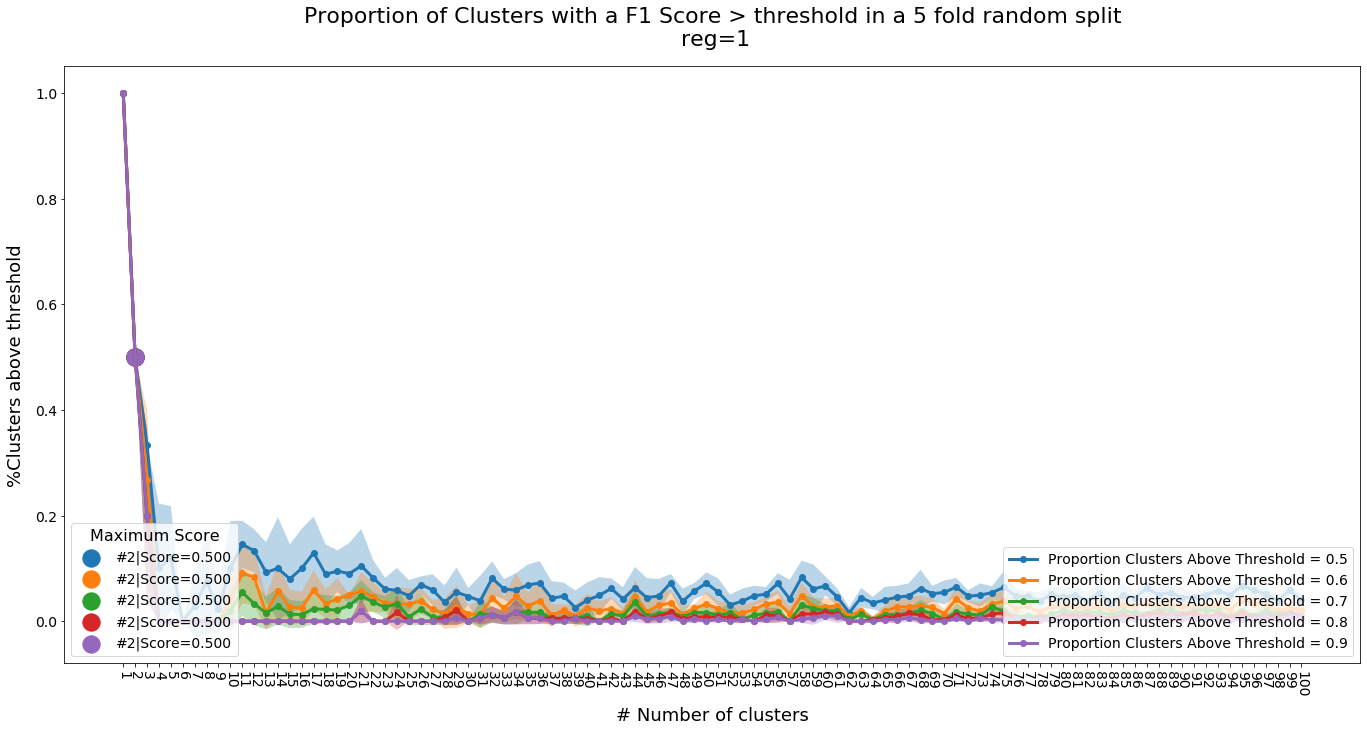

In [284]:
fig, ax = plt.subplots(figsize=figsize)
k_clusters = range(1,101)
#score_name = "F1-Score"
#score_name = "#Cluster above threshold=%.2f" % threshold
#score_name = "#Bursts in Clusters above threshold normalized by validation set size"
#score_name = "% of Clear Cluster Bursts in Clusters above threshold"
#score_name = "#Bursts in Clusters above threshold"
#score_name = "#Bursts in Clusters above threshold"
#title = "Number of Bursts in Clusters with a F1 Score > threshold in a 5 fold random split\n reg=1" 
score_name = "%Clusters above threshold"
title = "Proportion of Clusters with a F1 Score > threshold in a 5 fold random split\n reg=1" 

max_points_labels = []
max_points = []
lines = []

for i,key in enumerate(list(score_dict.keys())):
    mean_scores = score_dict[key][0]#np.mean(np.asarray(mean_clusterwise_folds),axis=0)
    std_scores = score_dict[key][1]#np.std(np.asarray(mean_clusterwise_folds),axis=0)
    argmax_scores = np.argmax(mean_scores[1:]) + 1

    lines += ax.plot(k_clusters, mean_scores, "o-", label=key, color = "C0%d" % i,linewidth=3)
    max_points += [ax.scatter(k_clusters[argmax_scores], mean_scores[argmax_scores], color = "C0%d" % i, marker="o",s=300)]
    max_points_labels +=  ["#%d|Score=%.3f" % (k_clusters[argmax_scores], mean_scores[argmax_scores])]
    plt.fill_between(k_clusters, mean_scores-std_scores, mean_scores+std_scores, alpha=.3)

#ax.annotate("#%d|Score=%.3f" % (argmax_f1+1, F1_scores[argmax_f1]), (k_clusters[argmax_f1] - 1, F1_scores[argmax_f1] + 0.03 - i*0.03), fontsize=16, color = "C0%d" % i)


ax.set_title(title, fontsize=22, pad=20)
ax.set_xticks(k_clusters)
ax.set_xlabel("# Number of clusters", fontsize=18, labelpad=10)
ax.set_ylabel(score_name, fontsize=18, labelpad=10),
#ax.set_ylim((0, 1.1))
ax.tick_params(axis='y',labelsize=14)
ax.tick_params(axis='x',labelsize=14,rotation=-90)

#ax.set_yticks(np.arange(0, 1.1,0.1))
left = plot_adjustments[0]
bottom = plot_adjustments[1]
right = plot_adjustments[2]
top = plot_adjustments[3]

plt.subplots_adjust(left,bottom,right, top)

ax.legend(lines, list(score_dict.keys()),fontsize = 14, loc="lower right")
leg = Legend(ax, max_points,max_points_labels,fontsize = 14, loc="lower left", title = "Maximum Score", )
leg.get_title().set_fontsize('16')
ax.add_artist(leg)
plt.savefig(save_file)